In [1]:
# Add soundsig to path to get coherence2.
# At some point this can be packaged and pip installed
import sys
sys.path.append("../soundsig")

In [2]:
## Dependencies
from scipy import stats
from coherence2 import multitapered_coherence
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook


<IPython.core.display.Javascript object>


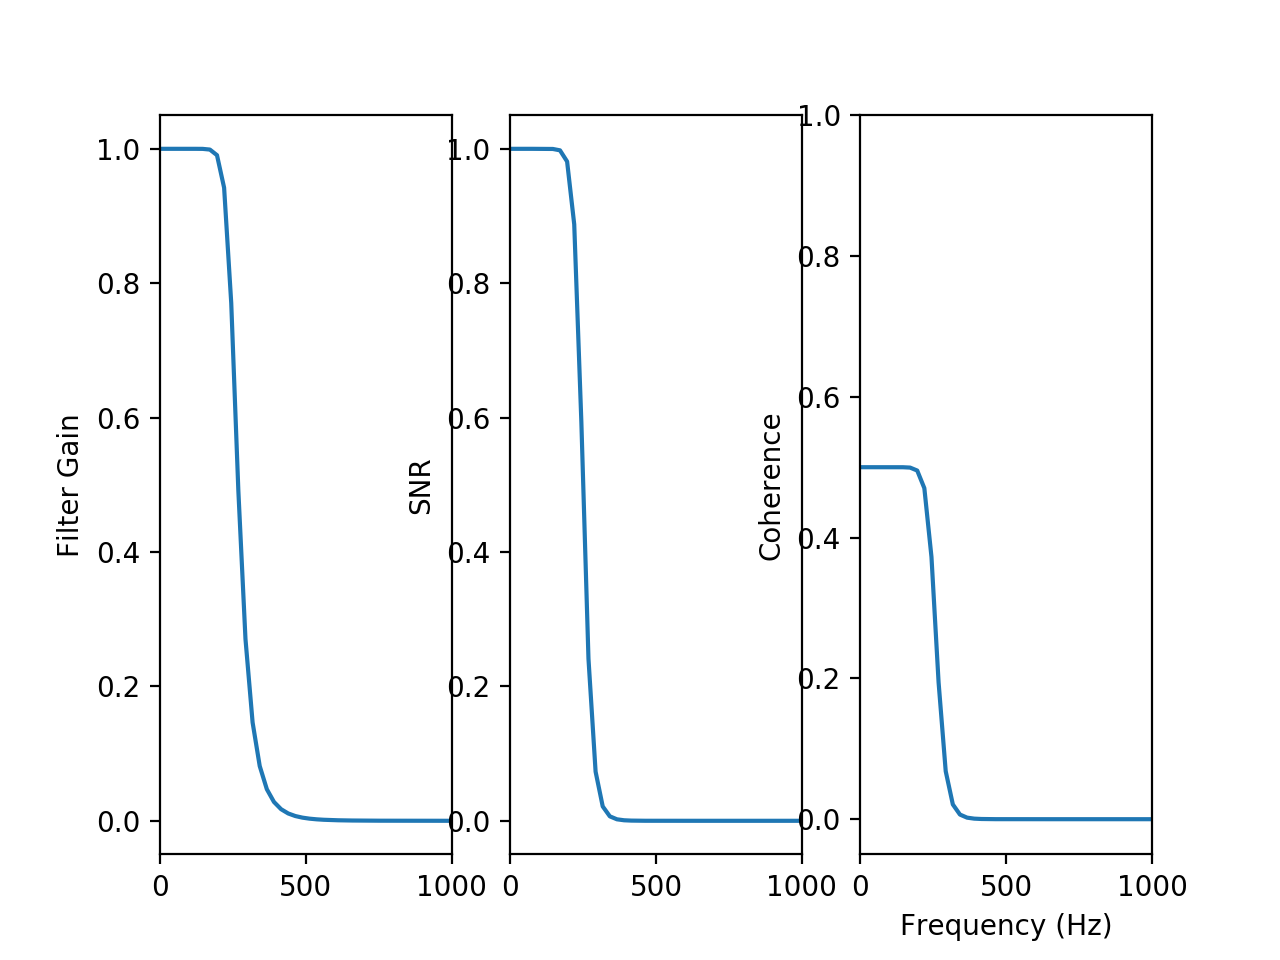

Text(0.5, 0, 'Frequency (Hz)')

In [3]:
# Make two signals - one is a low-pass filtered delayed version of the other

############################ Change these values to check and assess behavior
# Sampling Rate
fs = 25000             # Typical Sampling Rate for Intan
T = 20                 # Stimulus duration in s
SNR = 1                # Signal to Noise Ratio
Delay = 0.01            # 10 ms delay
cutoffFreq = 250       # 250 Hz frequency for low-pass filter
chunkSize = 13         # Chunk Size in log2()  12=4096


#############################################################


N = int(fs*T)                # Number of points in signals
time = np.arange(N) / fs     # Time array for plots
delay = int(Delay * fs)      # Delay in number of points

# Design the filter
b, a = signal.butter(8, cutoffFreq, btype='low', analog=False, output='ba', fs=fs)

# Plot the frequency gain, SNR and Expected Coherence
w, h = signal.freqz(b, a)
plt.figure()
plt.subplot(1,3,1)
plt.plot(w*fs/(2*np.pi), abs(h))
plt.ylabel('Filter Gain')
plt.xlim([0, 1000])

plt.subplot(1,3,2)
plt.plot(w*fs/(2*np.pi), (abs(h)**2)*SNR)
plt.ylabel('SNR')
plt.xlim([0, 1000])

plt.subplot(1,3,3)
plt.plot(w*fs/(2*np.pi), (abs(h)**2)*SNR/(1+(abs(h)**2)*SNR))
plt.ylabel('Coherence')
plt.xlim([0, 1000])
plt.ylim([-0.05,1])
plt.xlabel('Frequency (Hz)')




In [4]:
## Generate signals
x = np.random.normal(scale=1, size=time.shape)  # Input signal

beep = np.zeros_like(x)
if (delay == 0) :
    beep = x
else:
    beep = np.zeros_like(x)
    beep[delay:] = x[:-delay]
    
y = signal.filtfilt(b, a, x)  # Output signal is delayed and low-pass filtered...
y += np.random.normal(scale=np.sqrt(1/SNR), size=time.shape) # and noise is added.

if (delay != 0):
    y[delay:] = y[:-delay]
    y[0:delay] = y[delay]/(delay- np.linspace(0,delay, num=delay, endpoint=False))

f, Pxx = signal.welch(x, fs=fs, window='hann', nperseg=2**chunkSize, noverlap=2**(chunkSize-1))
f, Pyy = signal.welch(y, fs=fs, window='hann', nperseg=2**chunkSize, noverlap=2**(chunkSize-1))

<IPython.core.display.Javascript object>


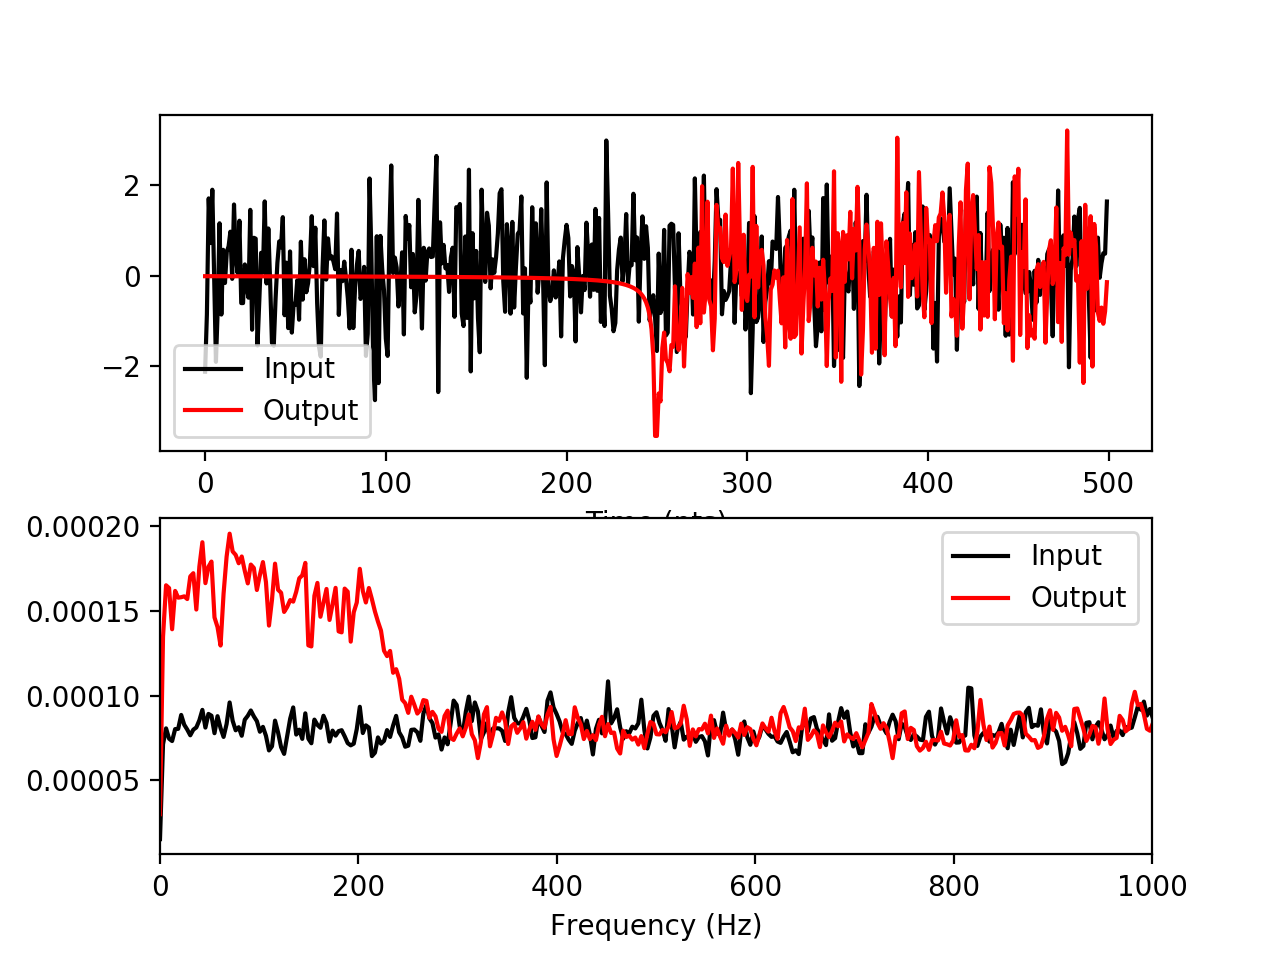

In [5]:
## Plot Signals

plt.figure()
plt.subplot(2,1,1)
plt.plot(x[0:500],'k', label='Input')
plt.plot(y[0:500],'r', label='Output')
plt.xlabel('Time (pts)')
plt.legend()
plt.subplot(2,1,2)
plt.plot(f, Pxx,'k', label='Input')
plt.plot(f, Pyy,'r', label='Output')
plt.xlim(0,1000)
plt.xlabel('Frequency (Hz)')
plt.legend()

In [6]:
# Calculate the coherence

# Multi-tapered + JN
result = multitapered_coherence([
    np.array([x, y]),
], sampling_rate=fs, chunk_size=2**chunkSize)

# Welch
f, Cxy = signal.coherence(x, y, fs=fs, window='hann', nperseg=2**chunkSize, noverlap=2**(chunkSize-1))

/Users/frederictheunissen/anaconda3/lib/python3.7/site-packages/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/Users/frederictheunissen/anaconda3/lib/python3.7/site-packages/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
../soundsig/coherence2.py:244: RuntimeWarning: divide by zero encountered in arctanh
  est_sqrt_coherence = np.arctanh(np.abs(est_coherency))
../soundsig/coherence2.py:264: RuntimeWarning: divide by zero encountered in arctanh
  for x in cross_spectra_jn


<IPython.core.display.Javascript object>


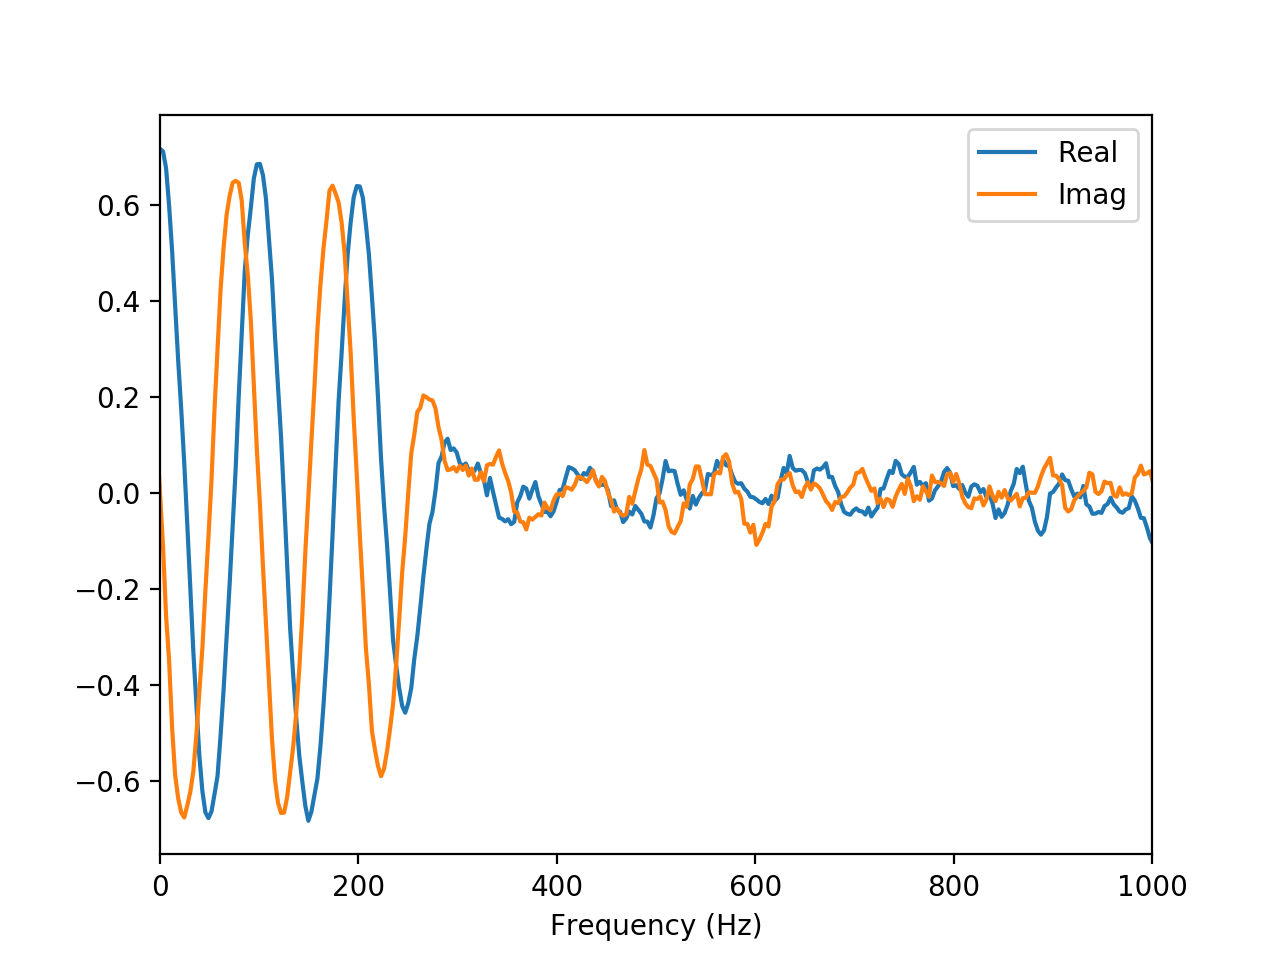

In [7]:
## Coherency in Spectral Domain. Some point make this a radial plot with colored segments

plt.figure()
plt.plot(np.fft.fftshift(result["freqs"]), np.fft.fftshift(np.real(result["coherency"][0, 1])), label='Real')
plt.plot(np.fft.fftshift(result["freqs"]), np.fft.fftshift(np.imag(result["coherency"][0, 1])), label='Imag')
plt.xlim([0, 1000.0])
plt.xlabel('Frequency (Hz)')
plt.legend()

<IPython.core.display.Javascript object>


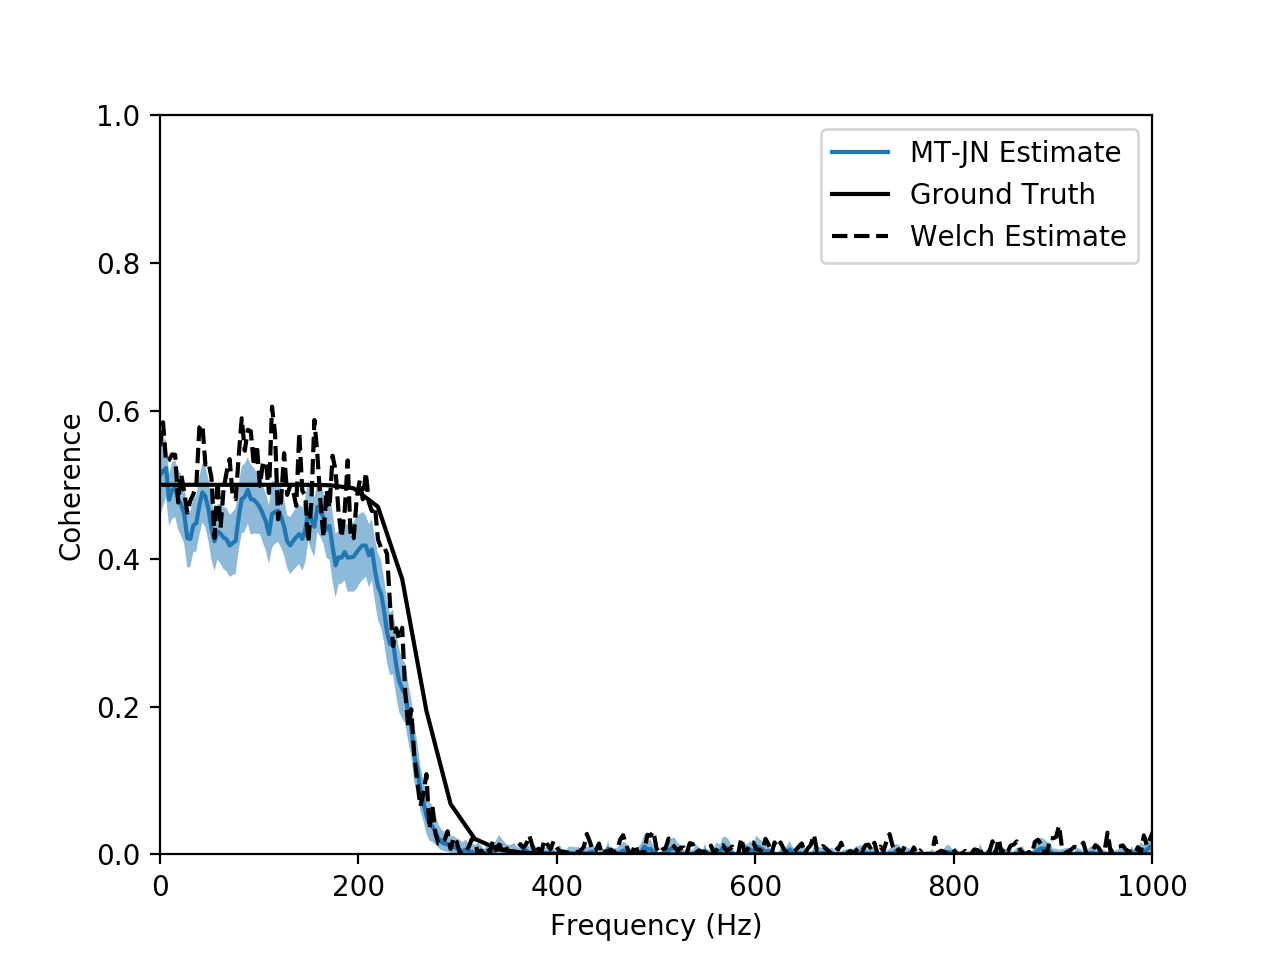

In [8]:
plt.figure()

plt.plot(np.fft.fftshift(result["freqs"]), np.fft.fftshift(np.abs(result["coherence"][0, 1])), label='MT-JN Estimate')
plt.plot(w*fs/(2*np.pi), (abs(h)**2)*SNR/(1+(abs(h)**2)*SNR), 'k', label='Ground Truth')
plt.plot(f, Cxy, 'k--', label='Welch Estimate')
plt.fill_between(
    np.fft.fftshift(result["freqs"]),
    np.fft.fftshift(np.abs(result["coherence_bounds"][0][0, 1])),
    np.fft.fftshift(np.abs(result["coherence_bounds"][1][0, 1])),
    alpha=0.5,
)

plt.ylim([0, 1])
plt.xlim([0, 1000.0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.legend()

<IPython.core.display.Javascript object>


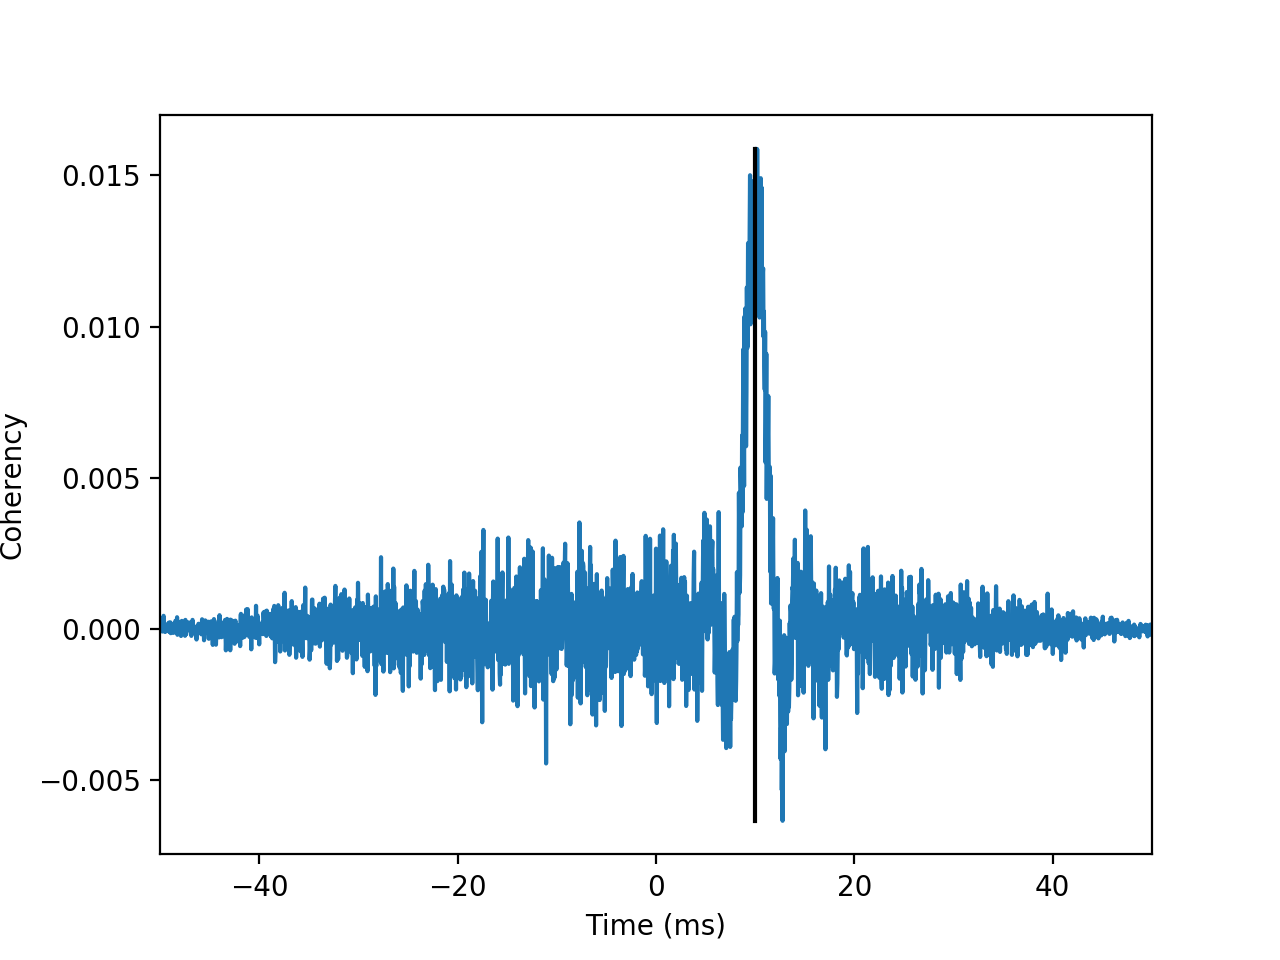

Text(0, 0.5, 'Coherency')

In [12]:
# The coherency in the time domain.
cxy = np.fft.fftshift(np.real(result["coherency_t"][0, 1]))
npts = cxy.size
t = np.arange(-npts/2 +1, npts/2+1)*1000.0/fs
plt.figure()
plt.plot(t, cxy)
plt.plot([Delay*1000, Delay*1000], [cxy.min(), cxy.max()], 'k')
plt.xlim(-50, 50)
plt.xlabel('Time (ms)')
plt.ylabel('Coherency')